In [1]:
library(org.Hs.eg.db)
library(AnnotationDbi)
library(ggplot2)
library(lumi)
library(missMethyl)
library(ggridges)

Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: IRanges

Loading required package: S4Vectors

In [2]:
missmethyl = readRDS("/nfs/dcmb-lgarmire/yhdu/COBRE Final Documents/Table 3 KEGG enrich missMethyl_v1.28.0/missmethyl_kegg.rds")

In [3]:
cobre_beta = readRDS("/nfs/dcmb-lgarmire/yhdu/COBRE Final Documents/Figure 1 Differential analysis/cobre_beta.rds")
cobre_pd = readRDS("/nfs/dcmb-lgarmire/yhdu/COBRE Final Documents/Figure 1 Differential analysis/cobre_pd.rds")

In [4]:
anno = readRDS("/nfs/dcmb-lgarmire/yhdu/COBRE Final Documents/Figure 1 Differential analysis/anno_450k.rds")

In [5]:
entrez_ids <- mapIds(org.Hs.eg.db, 
                     keys = unique(anno$UCSC_RefGene_Name), 
                     column = "ENTREZID", 
                     keytype = "SYMBOL", 
                     multiVals = "first")

'select()' returned 1:many mapping between keys and columns



In [6]:
gene_2_enz = as.data.frame(entrez_ids)

In [7]:
gene_2_enz$gene = names(entrez_ids)

In [8]:
getwd()

[1] "/nfs/dcmb-lgarmire/yhdu/COBRE Final Documents/Table 3 KEGG enrich missMethyl_v1.28.0"

In [12]:
save(anno,gene_2_enz,file='annotation_entrez.rdata')

In [9]:
CpG_anno_enz = merge(anno,gene_2_enz,by.x='UCSC_RefGene_Name',by.y='gene')

In [ ]:
CpG_anno_enz

In [16]:
saveRDS(CpG_anno_enz,'CpG_anno_entrez_id.rds')

In [10]:
CpG_anno_enz = readRDS('CpG_anno_entrez_id.rds')
#CpG_anno_enz[1:5,]

In [11]:
immune_pathways = c('path:hsa04640','path:hsa04610','path:hsa04611',
                    'path:hsa04613','path:hsa04620',
                    'path:hsa04621','path:hsa04622','path:hsa04623',
                    'path:hsa04625','path:hsa04650','path:hsa04612',
                    'path:hsa04660','path:hsa04658','path:hsa04659',
                    'path:hsa04657','path:hsa04662','path:hsa04664',
                    'path:hsa04666','path:hsa04670','path:hsa04672','path:hsa04062')

In [12]:
sig_limma = readRDS("/nfs/dcmb-lgarmire/yhdu/COBRE Final Documents/Figure 1 Differential analysis/cobre_limma_sig_1w5.RDS")

In [15]:
immune_list = as.data.frame(unlist(missmethyl$idList[immune_pathways]))
colnames(immune_list) = c('gene')
immune_markers = unique(immune_list$gene)
CpG_anno_enz_promoter = CpG_anno_enz[CpG_anno_enz$UCSC_RefGene_Group%in%c('TSS200','TSS1500'),]
immune_marker_CpG = CpG_anno_enz_promoter[CpG_anno_enz_promoter$entrez_ids%in%immune_markers,]$Name
immune_marker_CpG_sig = immune_marker_CpG[immune_marker_CpG%in%rownames(sig_limma)]

In [16]:
length(immune_marker_CpG_sig)

[1] 252

In [18]:
cobre_beta_immune = cobre_beta[rownames(cobre_beta)%in%immune_marker_CpG_sig,]
cobre_beta_immune_control = cobre_beta_immune[,cobre_pd[cobre_pd$Sample_Group=='control',]$Sample_Name]
cobre_beta_immune_obese = cobre_beta_immune[,cobre_pd[cobre_pd$Sample_Group=='obese',]$Sample_Name]
control_immune_mean = colMeans(cobre_beta_immune_control)
obese_immune_mean = colMeans(cobre_beta_immune_obese)

In [19]:
control_immune_df = cbind(control_immune_mean,rep('control',length(control_immune_mean)))
colnames(control_immune_df) = c('Mean_beta','Group')
obese_immune_df = cbind(obese_immune_mean,rep('obese',length(obese_immune_mean)))
colnames(obese_immune_df) = c('Mean_beta','Group')
immune_cpg = as.data.frame(rbind(control_immune_df,obese_immune_df))
immune_cpg$Mean_beta = as.numeric(immune_cpg$Mean_beta)

In [22]:
wilcox.test(control_immune_mean,obese_immune_mean)


	Wilcoxon rank sum exact test

data:  control_immune_mean and obese_immune_mean
W = 14, p-value < 2.2e-16
alternative hypothesis: true location shift is not equal to 0


In [43]:
plot_immune = ggplot(immune_cpg, aes(x = Group, y = Mean_beta, fill = Group)) +
  geom_violin(trim = FALSE) +
  labs(title = "Immune methylation score\n(Wilcox P < 2.2e-16)",
       x = "Group",
       y = "Mean Beta Value") +
  theme_minimal() +
    stat_summary(fun.data = "mean_cl_boot", geom = "crossbar",
               colour = "black", width = 0.2)

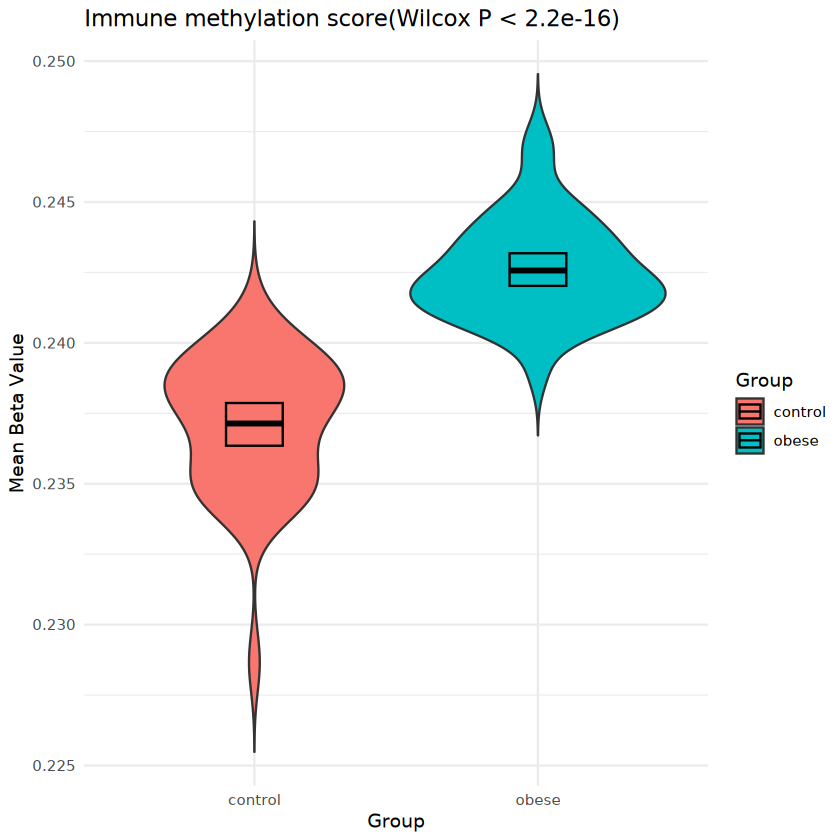

In [33]:
plot_immune

Picking joint bandwidth of 0.0594



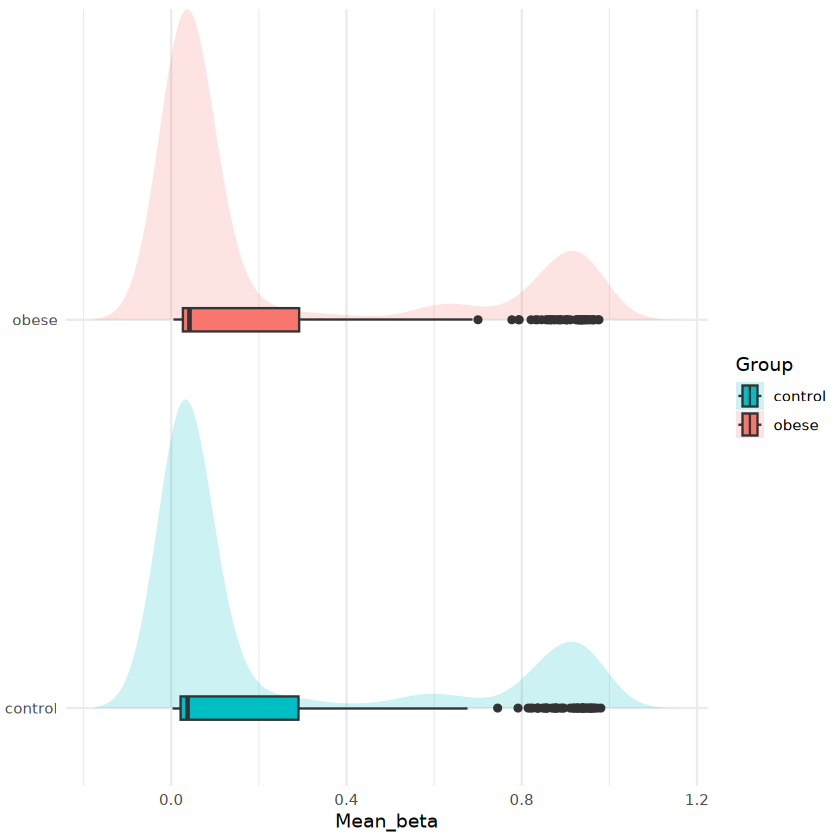

In [99]:
ggplot(immune_cpg, aes(x=Mean_beta, y=Group, fill=Group)) +
  scale_fill_manual(values = c("#00BFC4", "#F8766D"))+
  geom_density_ridges(aes(fill = Group), alpha=0.2, scale=0.8,color='transparent') +
  geom_boxplot(aes(fill = Group), width = 0.06)+theme_minimal()+scale_y_discrete(expand = c(0,0.2))+ 
  theme(plot.title = element_text(size=9),axis.title.y = element_blank())


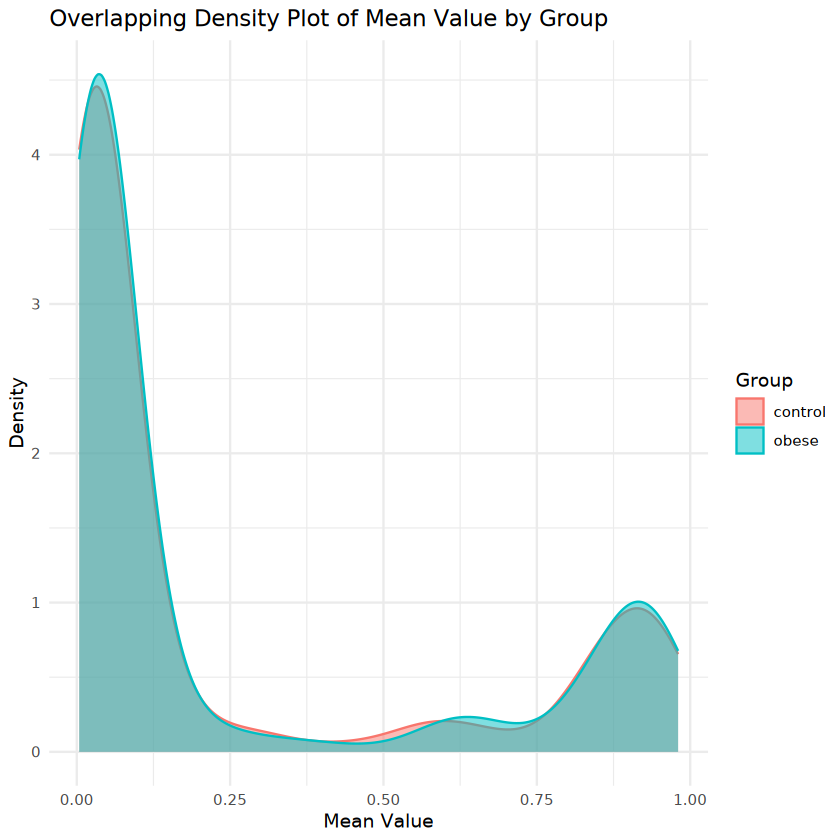

In [55]:
ggplot(immune_cpg, aes(x = Mean_beta, fill = Group, color = Group)) +
  geom_density(alpha = 0.5) +
  labs(title = "Overlapping Density Plot of Mean Value by Group",
       x = "Mean Value",
       y = "Density") +
  theme_minimal()

In [14]:
protein_pathways = c('path:hsa03020','path:hsa03022','path:hsa03040','path:hsa03010',
                     'path:hsa03013','path:hsa03015','path:hsa03008','path:hsa03060',
                     'path:hsa04141','path:hsa04130','path:hsa04120','path:hsa04122',
                     'path:hsa03050','path:hsa03018')

protein_pathways_synthesis = c('path:hsa03020','path:hsa03022','path:hsa03040','path:hsa03010',
                     'path:hsa03013','path:hsa03015','path:hsa03008','path:hsa03060',
                     'path:hsa04141','path:hsa04130')

In [25]:
protein_list = as.data.frame(unlist(missmethyl$idList[protein_pathways]))
colnames(protein_list) = c('gene')
protein_markers = unique(protein_list$gene)
CpG_anno_enz_promoter = CpG_anno_enz[CpG_anno_enz$UCSC_RefGene_Group%in%c('TSS200','TSS1500'),]
protein_marker_CpG = CpG_anno_enz_promoter[CpG_anno_enz_promoter$entrez_ids%in%protein_markers,]$Name
protein_marker_CpG_sig = protein_marker_CpG[protein_marker_CpG%in%rownames(sig_limma)]

In [26]:
cobre_beta_protein = cobre_beta[rownames(cobre_beta)%in%protein_marker_CpG_sig,]
cobre_beta_protein_control = cobre_beta_protein[,cobre_pd[cobre_pd$Sample_Group=='control',]$Sample_Name]
cobre_beta_protein_obese = cobre_beta_protein[,cobre_pd[cobre_pd$Sample_Group=='obese',]$Sample_Name]
control_protein_mean = colMeans(cobre_beta_protein_control)
obese_protein_mean = colMeans(cobre_beta_protein_obese)

In [27]:
control_protein_df = cbind(control_protein_mean,rep('control',length(control_protein_mean)))
colnames(control_protein_df) = c('Mean_beta','Group')
obese_protein_df = cbind(obese_protein_mean,rep('obese',length(obese_protein_mean)))
colnames(obese_protein_df) = c('Mean_beta','Group')
protein_cpg = as.data.frame(rbind(control_protein_df,obese_protein_df))
protein_cpg$Mean_beta = as.numeric(protein_cpg$Mean_beta)

In [28]:
wilcox.test(control_protein_mean,obese_protein_mean)


	Wilcoxon rank sum exact test

data:  control_protein_mean and obese_protein_mean
W = 87, p-value = 1.504e-12
alternative hypothesis: true location shift is not equal to 0


In [42]:
plot_protein = ggplot(protein_cpg, aes(x = Group, y = Mean_beta, fill = Group)) +
  geom_violin(trim = FALSE) +
  labs(title = "Protein methylation score\n(Wilcox P = 1.504e-12)",
       x = "Group",
       y = "Mean Beta Value") +
  theme_minimal() +
    stat_summary(fun.data = "mean_cl_boot", geom = "crossbar",
               colour = "black", width = 0.2)

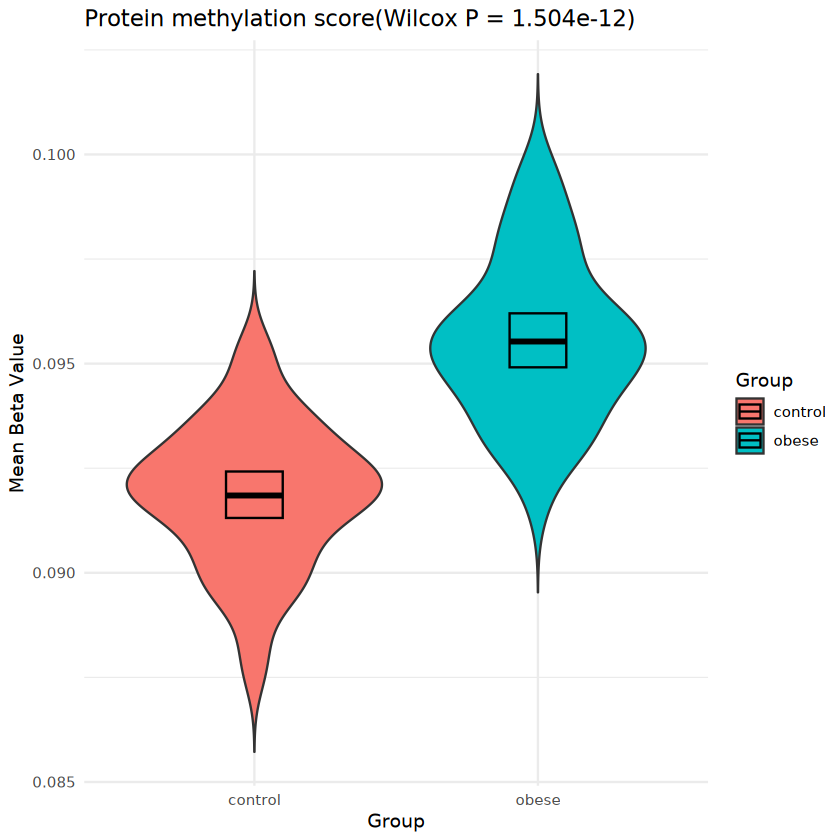

In [35]:
plot_protein

In [44]:
png('plot_immune.png',width=4,height=3,unit='in',res=300)
plot_immune
dev.off()

png 
  2

In [45]:
png('plot_protein.png',width=4,height=3,unit='in',res=300)
plot_protein
dev.off()

png 
  2

In [58]:
load("/nfs/dcmb-lgarmire/yhdu/COBRE Final Documents/RNA-seq analysis/RNA_normalized_log_counts.rdata",verbose=TRUE)

Loading objects:
  pd
  dds
  normalized_counts
  lognormalized_counts


In [60]:
load('annotation_entrez.rdata',verbose=TRUE)

Loading objects:
  anno
  gene_2_enz


In [146]:
immune_list = as.data.frame(unlist(missmethyl$idList[protein_pathways]))
colnames(immune_list) = c('gene')
immune_markers = unique(immune_list$gene)
CpG_anno_enz_promoter = CpG_anno_enz[CpG_anno_enz$UCSC_RefGene_Group%in%c('TSS200','TSS1500'),]
immune_marker_gene = unique(CpG_anno_enz_promoter[CpG_anno_enz_promoter$entrez_ids%in%immune_markers,]$UCSC_RefGene_Name)
gene_immune = lognormalized_counts[rownames(lognormalized_counts)%in%immune_marker_gene,]

In [147]:
dim(gene_immune)

[1] 888  47

In [148]:
cobre_beta_immune_control = gene_immune[,colnames(gene_immune)%in%cobre_pd[cobre_pd$Sample_Group=='control',]$Sample_Name]
cobre_beta_immune_obese = gene_immune[,colnames(gene_immune)%in%cobre_pd[cobre_pd$Sample_Group=='obese',]$Sample_Name]

In [149]:
t.test(control_immune_mean,obese_immune_mean)


	Welch Two Sample t-test

data:  control_immune_mean and obese_immune_mean
t = -0.36055, df = 35.539, p-value = 0.7206
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.07291053  0.05090826
sample estimates:
mean of x mean of y 
 7.044081  7.055082 


In [150]:
control_immune_mean = colMeans(cobre_beta_immune_control)
obese_immune_mean = colMeans(cobre_beta_immune_obese)
control_immune_df = cbind(control_immune_mean,rep('control',length(control_immune_mean)))
colnames(control_immune_df) = c('Mean_beta','Group')
obese_immune_df = cbind(obese_immune_mean,rep('obese',length(obese_immune_mean)))
colnames(obese_immune_df) = c('Mean_beta','Group')
immune_gene = as.data.frame(rbind(control_immune_df,obese_immune_df))
immune_gene$Mean_beta = as.numeric(immune_gene$Mean_beta)

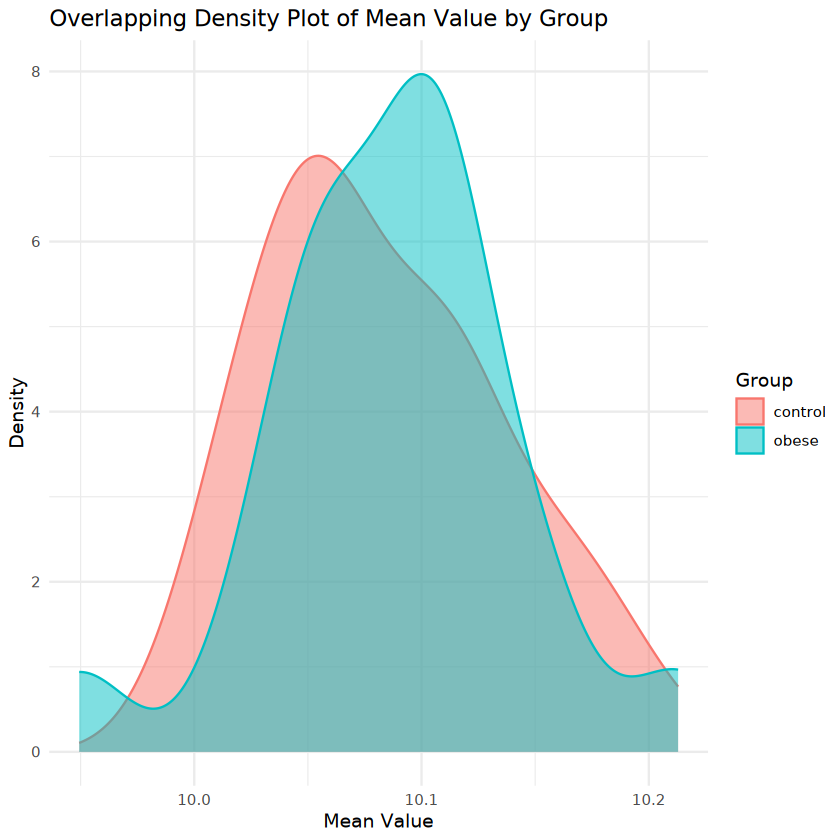

In [151]:
ggplot(immune_gene, aes(x = Mean_beta, fill = Group, color = Group)) +
  geom_density(alpha = 0.5) +
  labs(title = "Overlapping Density Plot of Mean Value by Group",
       x = "Mean Value",
       y = "Density") +
  theme_minimal()

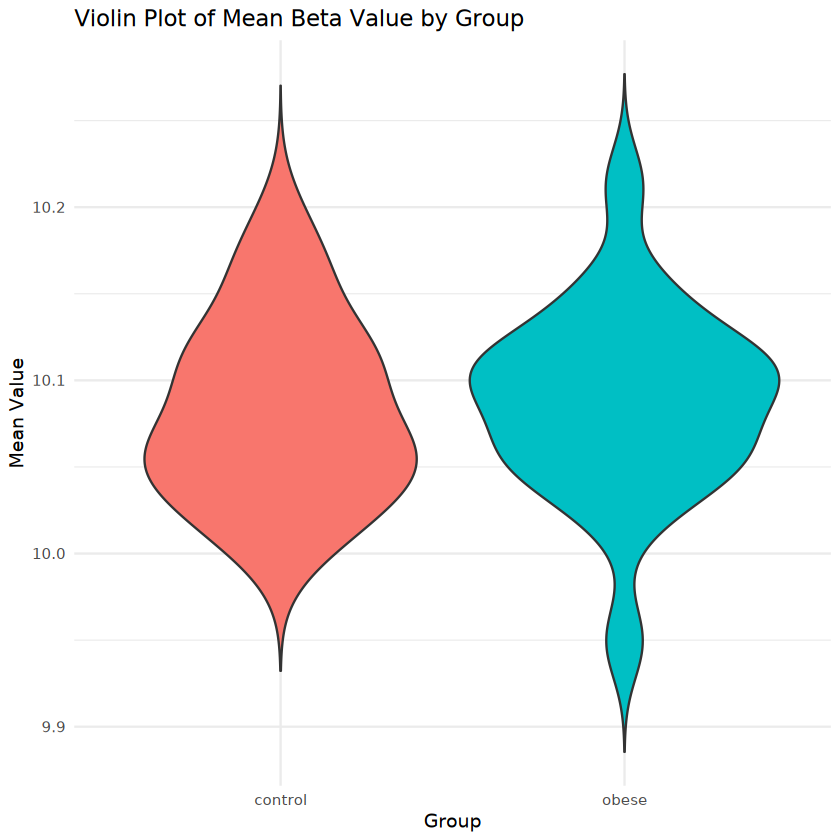

In [152]:
ggplot(immune_gene, aes(x = Group, y = Mean_beta, fill = Group)) +
  geom_violin(trim = FALSE) +
  labs(title = "Violin Plot of Mean Beta Value by Group",
       x = "Group",
       y = "Mean Value") +
  theme_minimal() +
  theme(legend.position = "none")